In [1]:
## This notebook will contain linear regression for
    # 1. Sunspot
    # 2. Mackey-Glass
    # 3. Lorenz

In [73]:
# import libraries 
import pandas as pd                                          # for reading dataset
import numpy as np
from reservoirpy.datasets import mackey_glass 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split         # for shuffling & splitting data

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression            # for model fitting
from sklearn.metrics import mean_squared_error               # for model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error   # https://scales.arabpsychology.com/stats/interpret-mape-values/

import matplotlib.pyplot as plt                              # for results visualisation

In [52]:
## Define function
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi step ahead version
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

In [4]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 10   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [89]:
# 1. Sunspot (Classic Linear regression)
Sunspot = pd.read_csv('data/Sunspots.csv')
response = Sunspot['Monthly Mean Total Sunspot Number']
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(response).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [6]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))

    actuals = list(zip(*y_test))
    preds = list(zip(*y_pred))
    
    for step in range(output_size):
        mse_step = mean_squared_error(preds[step], actuals[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Linear Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

Exp 1 on test set: RMSE: 0.0803, MAE: 22.36, MAPE: 1217712084068963.0000
Exp 2 on test set: RMSE: 0.0776, MAE: 22.53, MAPE: 966278764455048.6250
Exp 3 on test set: RMSE: 0.0761, MAE: 21.89, MAPE: 1279171795257160.2500
Exp 4 on test set: RMSE: 0.0805, MAE: 23.09, MAPE: 1017365087893911.5000
Exp 5 on test set: RMSE: 0.0793, MAE: 22.92, MAPE: 1089335787658290.8750
Exp 6 on test set: RMSE: 0.0796, MAE: 22.94, MAPE: 1106483343998635.8750
Exp 7 on test set: RMSE: 0.0776, MAE: 22.13, MAPE: 1410693647985819.7500
Exp 8 on test set: RMSE: 0.0812, MAE: 23.25, MAPE: 724404252908426.5000
Exp 9 on test set: RMSE: 0.0800, MAE: 23.19, MAPE: 1297758884738800.5000
Exp 10 on test set: RMSE: 0.0777, MAE: 22.36, MAPE: 970803749744046.6250
Exp 11 on test set: RMSE: 0.0798, MAE: 22.60, MAPE: 1192722087229397.7500
Exp 12 on test set: RMSE: 0.0797, MAE: 22.68, MAPE: 1454482406518150.0000
Exp 13 on test set: RMSE: 0.0789, MAE: 22.59, MAPE: 1713170017136190.7500
Exp 14 on test set: RMSE: 0.0819, MAE: 23.21, MAPE

In [ ]:
# MAPE not very suitable here: no need to report MAPE (not a useful model eval metric for this scenario)
# percentage difference across 6 steps stacks up quickly and the nature of the sunspots data are not suitable
    # e.g. actual = 0.1, pred = 10

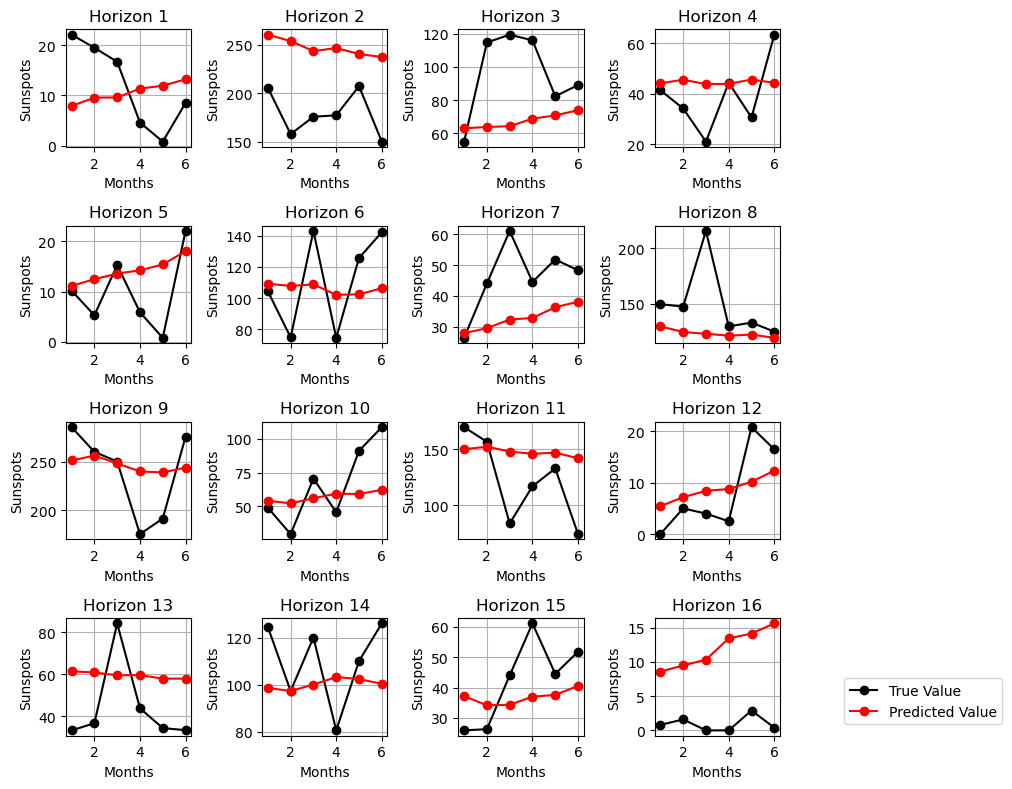

In [7]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [61]:
# Linear Regression Quantile ver

# Usage
input_size = 10        # 5 steps input
output_size = 6        # 3 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 10   # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [63]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))

    actuals = list(zip(*y_test))
    preds = list(zip(*results[0.5]))
    
    for step in range(output_size):
        mse_step = mean_squared_error(preds[step], actuals[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0820, MAE: 22.46, MAPE: 538809969166112.9375
Exp 2 on test set: RMSE: 0.0787, MAE: 22.45, MAPE: 492475744356864.4375
Exp 3 on test set: RMSE: 0.0767, MAE: 21.47, MAPE: 699987950655861.8750
Exp 4 on test set: RMSE: 0.0810, MAE: 22.77, MAPE: 485574756018245.5000
Exp 5 on test set: RMSE: 0.0800, MAE: 22.60, MAPE: 389149118283966.5000
Exp 6 on test set: RMSE: 0.0805, MAE: 22.72, MAPE: 496633643383495.5000
Exp 7 on test set: RMSE: 0.0790, MAE: 22.16, MAPE: 684002033251503.3750
Exp 8 on test set: RMSE: 0.0819, MAE: 23.07, MAPE: 300707924068536.0000
Exp 9 on test set: RMSE: 0.0813, MAE: 23.07, MAPE: 693722830541952.3750
Exp 10 on test set: RMSE: 0.0787, MAE: 22.10, MAPE: 426690947364815.1875
Exp 11 on test set: RMSE: 0.0811, MAE: 22.50, MAPE: 509691316897127.8125
Exp 12 on test set: RMSE: 0.0807, MAE: 22.39, MAPE: 652275603146844.3750
Exp 13 on test set: RMSE: 0.0800, MAE: 22.40, MAPE: 846782396476261.3750
Exp 14 on test set: RMSE: 0.0830, MAE: 23.01, MAPE: 51476109

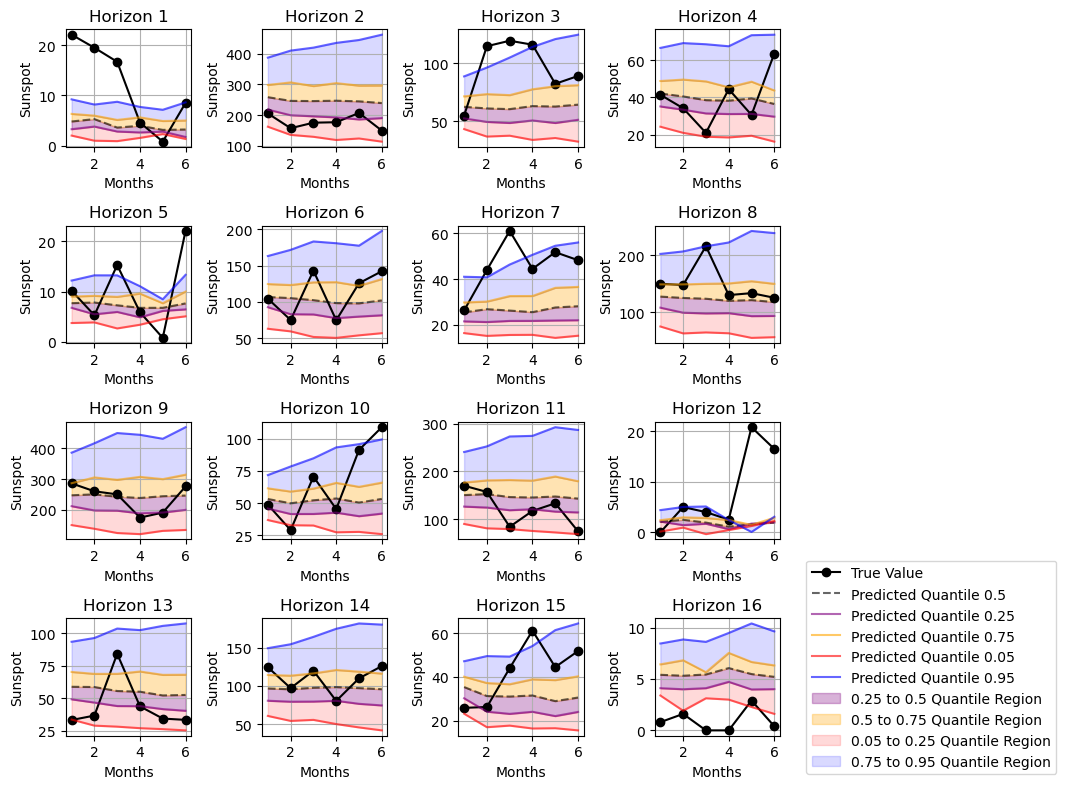

In [71]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspot')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [ ]:
# It seems that quantile regression have trouble handling values near 0
# Will be interesting to see its performance with chaotic time series...

In [91]:
# 2. Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))    # Set the index to be a range of integers

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [95]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [97]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))

    actuals = list(zip(*y_test))
    preds = list(zip(*y_pred))
    
    for step in range(output_size):
        mse_step = mean_squared_error(preds[step], actuals[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Linear Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

Exp 1 on test set: RMSE: 0.0401, MAE: 0.02, MAPE: 0.0207
Exp 2 on test set: RMSE: 0.0330, MAE: 0.02, MAPE: 0.0206
Exp 3 on test set: RMSE: 0.0360, MAE: 0.02, MAPE: 0.0214
Exp 4 on test set: RMSE: 0.0326, MAE: 0.02, MAPE: 0.0211
Exp 5 on test set: RMSE: 0.0351, MAE: 0.02, MAPE: 0.0206
Exp 6 on test set: RMSE: 0.0356, MAE: 0.02, MAPE: 0.0215
Exp 7 on test set: RMSE: 0.0291, MAE: 0.02, MAPE: 0.0195
Exp 8 on test set: RMSE: 0.0509, MAE: 0.02, MAPE: 0.0214
Exp 9 on test set: RMSE: 0.0343, MAE: 0.02, MAPE: 0.0225
Exp 10 on test set: RMSE: 0.0377, MAE: 0.02, MAPE: 0.0211
Exp 11 on test set: RMSE: 0.0326, MAE: 0.02, MAPE: 0.0218
Exp 12 on test set: RMSE: 0.0296, MAE: 0.02, MAPE: 0.0198
Exp 13 on test set: RMSE: 0.0407, MAE: 0.02, MAPE: 0.0220
Exp 14 on test set: RMSE: 0.0361, MAE: 0.02, MAPE: 0.0211
Exp 15 on test set: RMSE: 0.0614, MAE: 0.02, MAPE: 0.0228
Exp 16 on test set: RMSE: 0.0304, MAE: 0.02, MAPE: 0.0195
Exp 17 on test set: RMSE: 0.0305, MAE: 0.02, MAPE: 0.0205
Exp 18 on test set: RMS

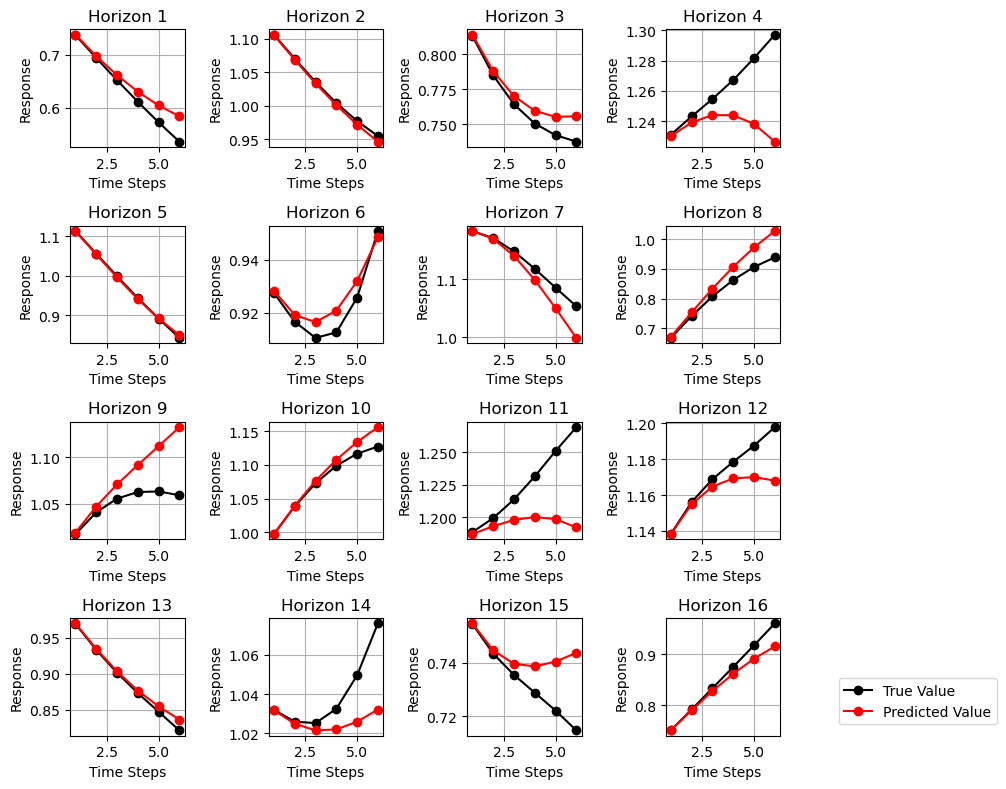

In [99]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [ ]:
# Amazing! :D
# Interestingly, prediction works better for chaotic time series

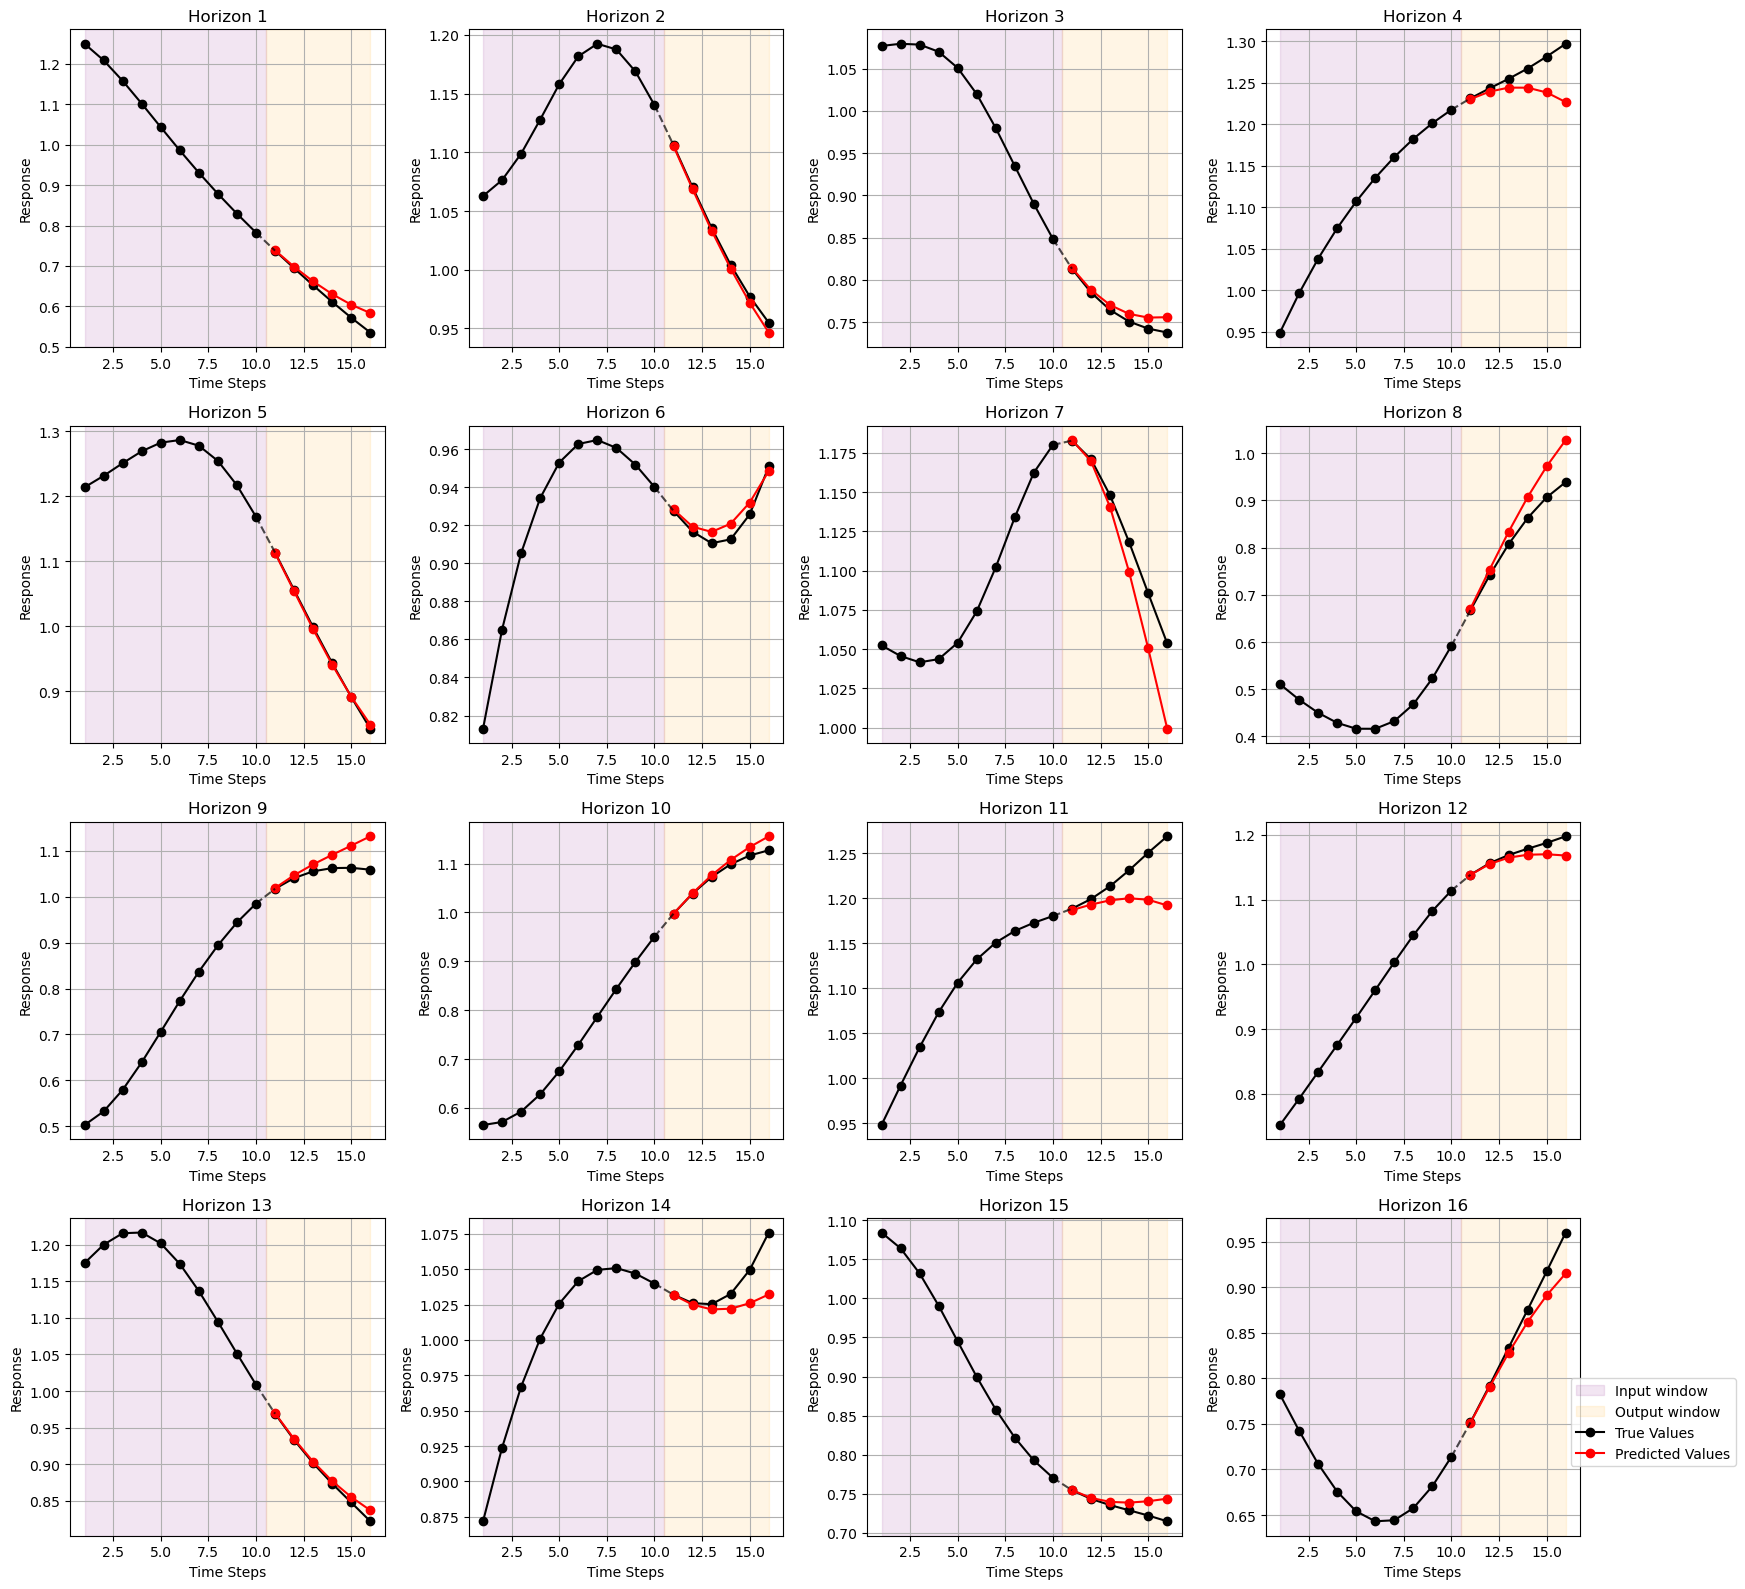

In [135]:
X_test_inv = scaler.inverse_transform(X_test)
y_test_inv = scaler.inverse_transform(y_test)

# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()
for i in range(16):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], y_test_inv[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], y_test_inv[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [151]:
## Quantile Ver: Linear Regression Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [153]:
# Usage
input_size = 10        # 5 steps input
output_size = 6        # 3 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 1   # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [155]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))

    actuals = list(zip(*y_test))
    preds = list(zip(*results[0.5]))
    
    for step in range(output_size):
        mse_step = mean_squared_error(preds[step], actuals[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0760, MAE: 0.02, MAPE: 0.0226
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0760, Avg MAE: 0.02, Avg MAPE: 2.258%
At time step 1, Avg RMSE: 0.0056, Avg MAE: 0.00, Avg MAPE: 0.107%
At time step 2, Avg RMSE: 0.0192, Avg MAE: 0.00, Avg MAPE: 0.448%
At time step 3, Avg RMSE: 0.0399, Avg MAE: 0.01, Avg MAPE: 1.156%
At time step 4, Avg RMSE: 0.0686, Avg MAE: 0.02, Avg MAPE: 2.281%
At time step 5, Avg RMSE: 0.0998, Avg MAE: 0.03, Avg MAPE: 3.839%
At time step 6, Avg RMSE: 0.1341, Avg MAE: 0.05, Avg MAPE: 5.718%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0670
At Quantile 0.25, it has Avg RMSE: 0.0718
At Quantile 0.5, it has Avg RMSE: 0.0760
At Quantile 0.75, it has Avg RMSE: 0.0831
At Quantile 0.95, it has Avg RMSE: 0.0973


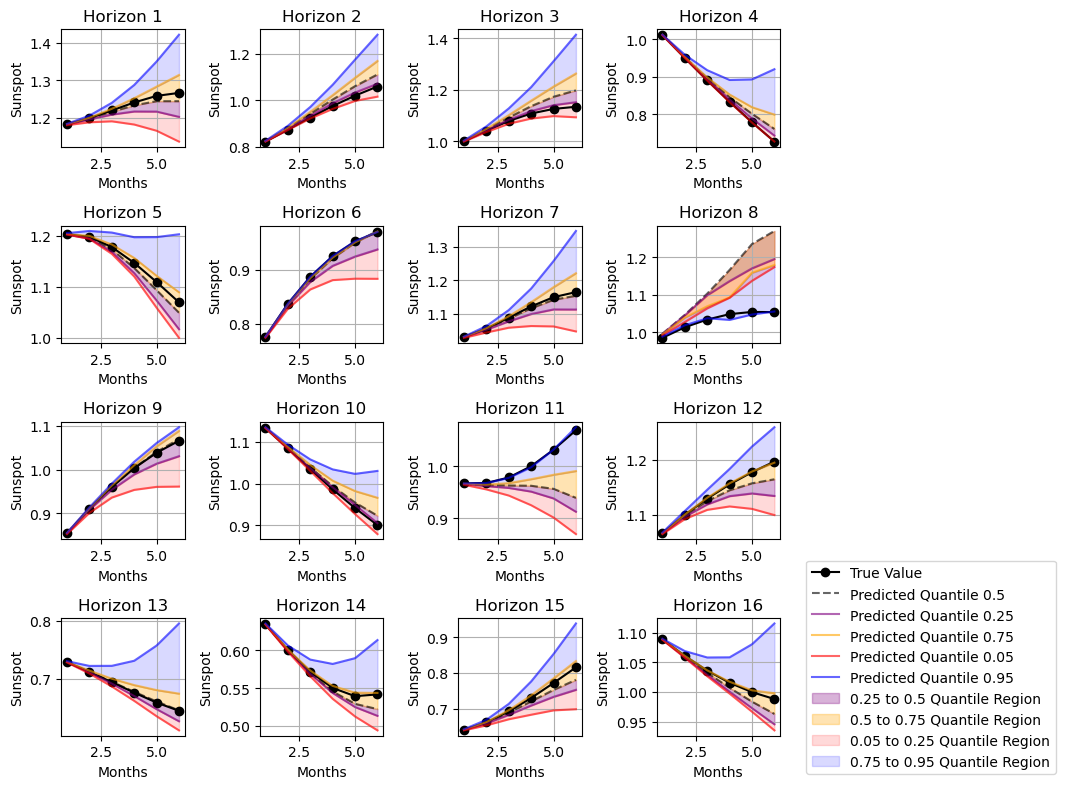

In [142]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspot')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [ ]:
# It's Beautiful... :')

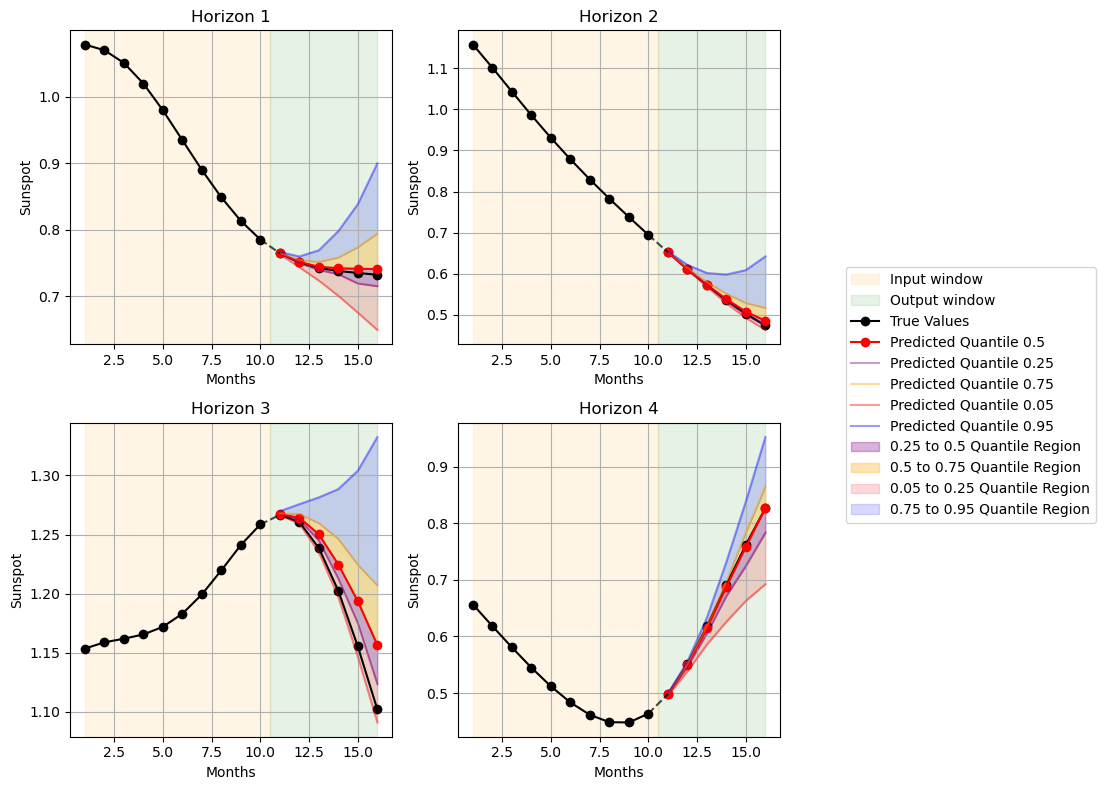

In [191]:
X_test_inv = scaler.inverse_transform(X_test)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='orange', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='green', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], actual_values[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], marker='o', linestyle='-', color='red', label='Predicted Quantile 0.5')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.4)
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], actual_values[i][0]], linestyle='--', color='black', alpha=0.7)

    # Highlight regions between quantiles
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspot')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()